In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


parental_level_of_education,math_score,reading_score,writing_score,mean_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
some college,55,64,68,62.33333
bachelor's degree,61,72,73,68.66667
master's degree,56,48,51,51.66667
⋮,⋮,⋮,⋮,⋮
high school,56,53,51,53.33333
some college,56,64,60,60.00000
bachelor's degree,62,70,72,68.00000


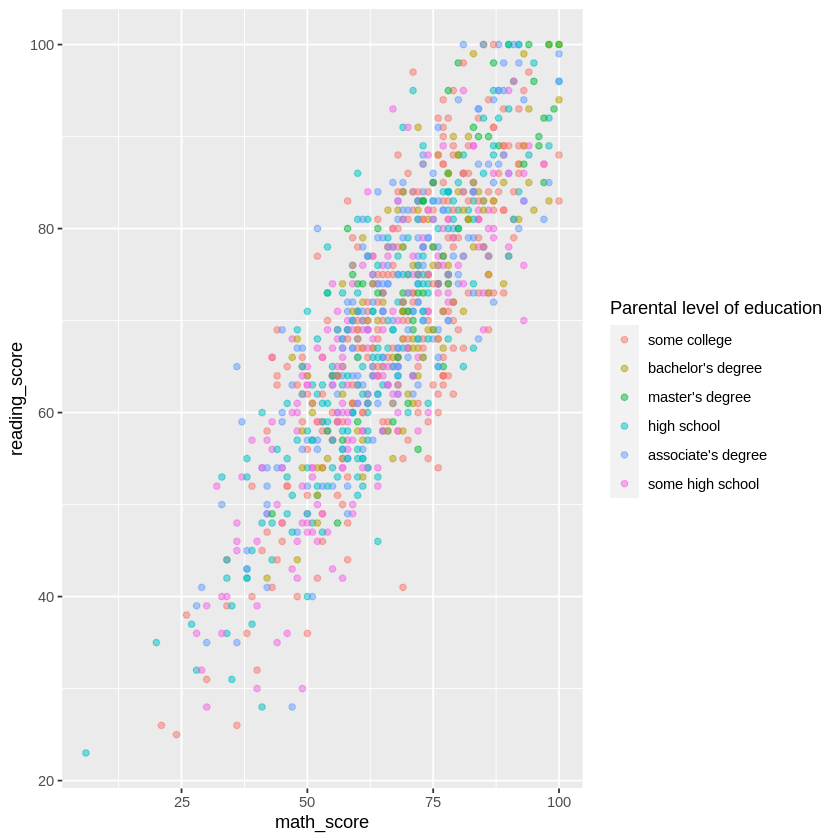

In [2]:
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data <- read_csv(url)
colnames(exam_data) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", 
                         "math_score", "reading_score", "writing_score")
exam_data1<- exam_data |>
mutate(parental_level_of_education = as_factor(parental_level_of_education)) |>
mutate("mean_score" = (math_score + reading_score + writing_score)/3) |>
select(parental_level_of_education, math_score, reading_score, writing_score, mean_score)

exam_data1

exam_graph <- exam_data1 |>
ggplot(aes(x = math_score, y = reading_score, color = parental_level_of_education)) +
geom_point(alpha = 0.5) +
labs(color = "Parental level of education")

exam_graph

#exam_graph <- exam_data1 |>
#ggplot(aes(x = mean_score, y = fct_reorder(parental_level_of_education, mean_score, .desc = TRUE), 
#           fill = parental_level_of_education)) +
#geom_bar(stat = "identity") + 
#labs(x = "Average Score", y = "Parental Level of Education",  fill = "type")

data_split <- initial_split(exam_data1, prop = 0.75, strata = parental_level_of_education)
data_train <- training(data_split)
data_test <- testing(data_split)

data_recipe <- recipe(parental_level_of_education ~ math_score + reading_score + writing_score, data = data_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2045802,5,0.005644821,Preprocessor1_Model01
2,accuracy,multiclass,0.2032557,5,0.006474139,Preprocessor1_Model02
3,accuracy,multiclass,0.1990758,5,0.005373062,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.1979584,5,0.010816462,Preprocessor1_Model08
9,accuracy,multiclass,0.1884798,5,0.006511055,Preprocessor1_Model09
10,accuracy,multiclass,0.1804431,5,0.004683872,Preprocessor1_Model10


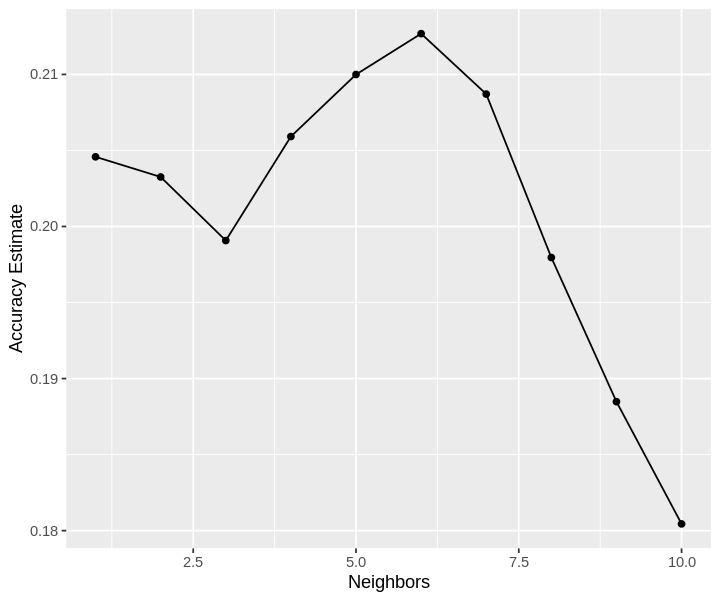

In [5]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10))
vfold <- vfold_cv(data_train, v = 5, strata = parental_level_of_education)
recipe <- recipe(parental_level_of_education ~., data = data_train)

knn_results <- workflow() |>
add_recipe(recipe) |>
add_model(knn_spec)|>
tune_grid(resamples = vfold, grid = k_vals) |>
collect_metrics()

accuracies <- knn_results |>
filter(.metric == "accuracy")

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot

In [3]:
pivot_wider(exam_data1,
           names_from = parental_level_of_education,
           values_from = mean_score)

Warning message:
“Values from `mean_score` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = {summary_fun}` to summarise duplicates.
* Use the following dplyr code to identify duplicates.
  {data} %>%
    dplyr::group_by(math_score, reading_score, writing_score, parental_level_of_education) %>%
    dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
    dplyr::filter(n > 1L)”


math_score,reading_score,writing_score,some college,bachelor's degree,master's degree,high school,associate's degree,some high school
<dbl>,<dbl>,<dbl>,<list>,<list>,<list>,<list>,<list>,<list>
55,64,68,62.33333,NULL,NULL,NULL,NULL,NULL
61,72,73,NULL,68.66667,NULL,NULL,NULL,NULL
56,48,51,NULL,NULL,51.66667,NULL,NULL,NULL
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,53,51,NULL,NULL,NULL,53.33333,NULL,NULL
56,64,60,60,NULL,NULL,NULL,NULL,NULL
62,70,72,NULL,68,NULL,NULL,NULL,NULL


In [4]:
group_by(exam_data1, parental_level_of_education) |>
summarize(below_bachelor = some)

parental_level_of_education,math_score,reading_score,writing_score,mean_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
some college,55,64,68,62.33333
bachelor's degree,61,72,73,68.66667
master's degree,56,48,51,51.66667
⋮,⋮,⋮,⋮,⋮
high school,56,53,51,53.33333
some college,56,64,60,60.00000
bachelor's degree,62,70,72,68.00000


In [7]:
exam_data

gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
female,group B,some college,standard,none,55,64,68
female,group B,bachelor's degree,free/reduced,none,61,72,73
female,group C,master's degree,standard,none,56,48,51
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
male,group B,high school,standard,none,56,53,51
female,group C,some college,standard,none,56,64,60
male,group C,bachelor's degree,free/reduced,completed,62,70,72


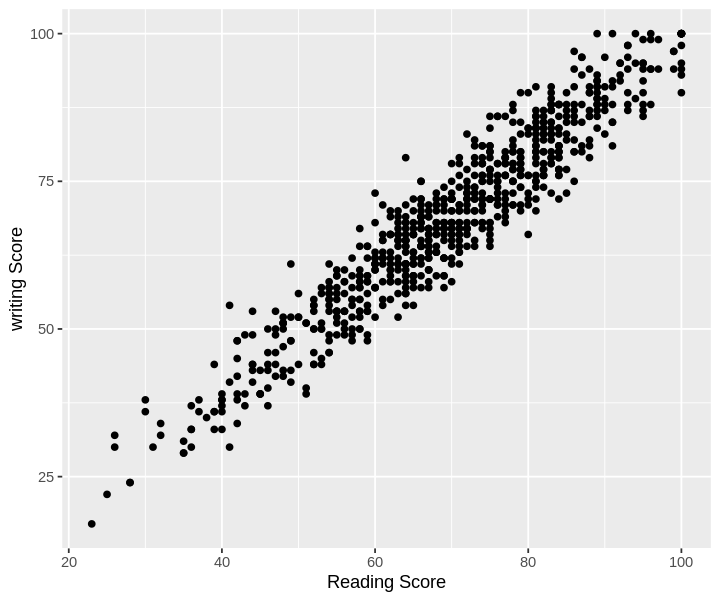

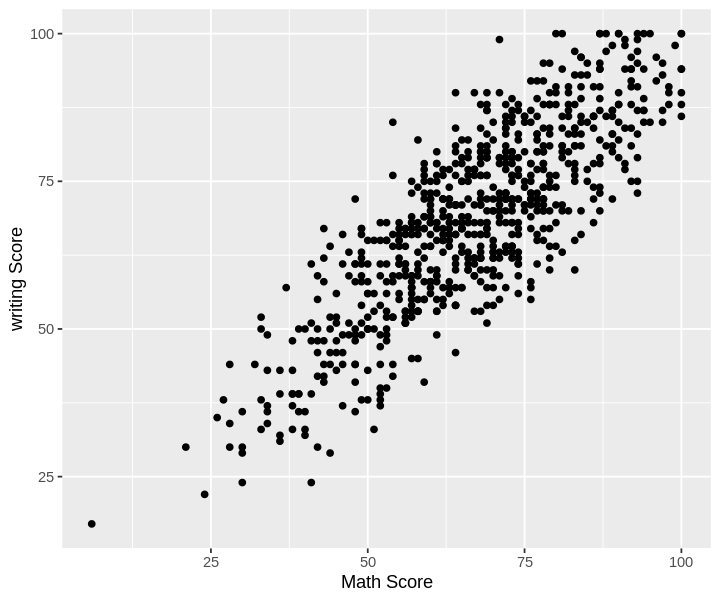

student,math_score,reading_score,writing_score,mean_score
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,55,64,68,62.33333
2,61,72,73,68.66667
3,56,48,51,51.66667
⋮,⋮,⋮,⋮,⋮
998,56,53,51,53.33333
999,56,64,60,60.00000
1000,62,70,72,68.00000


student,math_score,reading_score,writing_score,mean_score
<int>,<dbl>,<dbl>,<dbl>,<dbl>
4,52,54,54,53.33333
19,57,56,58,57.00000
21,70,57,54,60.33333
⋮,⋮,⋮,⋮,⋮
984,78,95,92,88.33333
994,81,95,94,90.00000
997,98,100,100,99.33333


student,math_score,reading_score,writing_score,mean_score
<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,56,48,51,51.66667
6,69,73,79,73.66667
12,55,64,65,61.33333
⋮,⋮,⋮,⋮,⋮
993,84,79,85,82.66667
995,56,69,66,63.66667
999,56,64,60,60.00000


    student         math_score     reading_score    writing_score   
 Min.   :   1.0   Min.   :  6.00   Min.   : 23.00   Min.   : 17.00  
 1st Qu.: 247.5   1st Qu.: 57.00   1st Qu.: 60.00   1st Qu.: 58.00  
 Median : 504.5   Median : 67.00   Median : 70.00   Median : 69.00  
 Mean   : 503.3   Mean   : 66.74   Mean   : 69.53   Mean   : 68.55  
 3rd Qu.: 759.2   3rd Qu.: 78.00   3rd Qu.: 81.00   3rd Qu.: 80.00  
 Max.   :1000.0   Max.   :100.00   Max.   :100.00   Max.   :100.00  
   mean_score    
 Min.   : 15.33  
 1st Qu.: 58.67  
 Median : 68.33  
 Mean   : 68.27  
 3rd Qu.: 78.67  
 Max.   :100.00  

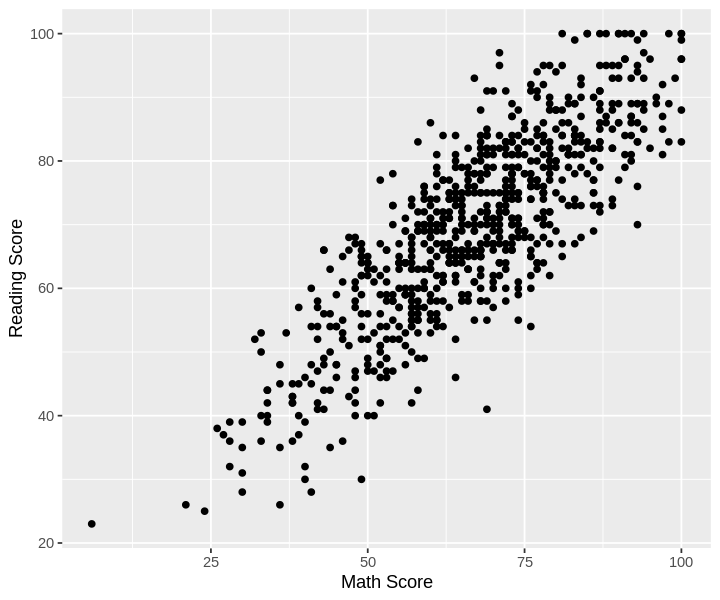

In [21]:
graph1 <- ggplot(data_train, aes(x = reading_score, y = writing_score)) +
geom_point() +
xlab("Reading Score") +
ylab("writing Score")

graph2 <- ggplot(data_train, aes(x = math_score, y = writing_score)) +
geom_point() +
xlab("Math Score") +
ylab("writing Score")

graph3 <- ggplot(data_train, aes(x = math_score, y = reading_score)) +
geom_point() +
xlab("Math Score") +
ylab("Reading Score")

graph1
graph2
graph3

exam_data1<- exam_data |>
mutate("mean_score" = (math_score + reading_score + writing_score)/3) |>
mutate(student = seq(from = 1, to = 1000)) |>
select(student, math_score, reading_score, writing_score, mean_score)

exam_data1

data_split <- initial_split(exam_data1, prop = 0.75, strata = reading_score)
data_train <- training(data_split)
data_test <- testing(data_split)

data_train
data_test
summary(data_train)

In [31]:
data_recipe <- recipe(reading_score ~ writing_score, data = data_train) |>
 step_scale(all_predictors()) |>
 step_center(all_predictors())

data_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

data_vfold <- vfold_cv(data_train, v = 5, strata = reading_score)

data_wkflw <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(data_spec)

data_wkflw

gridvals <- tibble(neighbors = seq(1, 200, by = 3))

data_results <- data_wkflw |>
tune_grid(resamples = data_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse")

data_results

data_multi <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(data_spec) |>
  tune_grid(data_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

data_k <- data_multi |>
              pull(neighbors)

data_multi

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,7.832251,5,0.1312426,Preprocessor1_Model01
4,rmse,standard,5.868433,5,0.1143368,Preprocessor1_Model02
7,rmse,standard,5.408942,5,0.1230071,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
193,rmse,standard,6.755264,5,0.4156809,Preprocessor1_Model65
196,rmse,standard,6.798169,5,0.4173252,Preprocessor1_Model66
199,rmse,standard,6.832270,5,0.4176812,Preprocessor1_Model67


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,4.83887,5,0.1085258,Preprocessor1_Model09


In [33]:
data_spec <- nearest_neighbor(weight_func = "rectangular",  neighbors = 25) |>
set_engine("kknn")|>
set_mode("regression")

data_fit <- workflow() |>
add_recipe(data_recipe) |>
add_model(data_spec)|>
fit(data = data_train)

data_summary <- data_fit |>
predict(data_test) |>
bind_cols(data_test) |>
metrics(truth = reading_score, estimate = .pred) |>
filter(.metric == 'rmse')

data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.373487


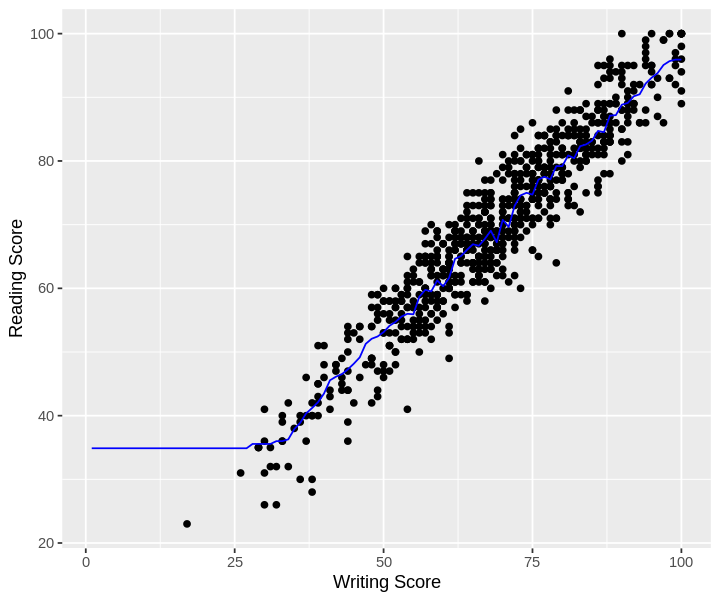

In [35]:
data_preds <- tibble(writing_score = seq(1:100))

data_preds <- data_fit |>
predict(data_preds) |>
bind_cols(data_preds)

plot <- ggplot(data_train, aes(x = writing_score, y = reading_score)) +
geom_point() +
geom_line(data = data_preds,
         mapping = aes(x = writing_score, y = .pred),
         color = "blue") +
xlab("Writing Score") +
ylab("Reading Score") 

plot

In [37]:
nearest_neighbors <- data_train |>
mutate(diff = abs(100 - writing_score)) |>
arrange(diff) |>
slice(1:5)

nearest_neighbors

student,math_score,reading_score,writing_score,mean_score,diff
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
91,81,100,100,93.66667,0
281,100,100,100,100.00000,0
343,95,98,100,97.66667,0
572,87,91,100,92.66667,0
598,80,94,100,91.33333,0


In [39]:
prediction <- nearest_neighbors |>
summarize(predicted = mean(reading_score))

prediction

predicted
<dbl>
96.6
